In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['testimage', 'imageclassification']


### Importing the Necessary Libararies 

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPool2D
from tensorflow.keras.layers import Input, Dense
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [3]:
PATH = os.getcwd()
print(PATH)
PATH = '../input/imageclassification/10_categories-1551435405057/10_categories'
print(os.listdir(PATH))
data_dir_list = os.listdir(PATH)
print(data_dir_list)

/kaggle/working
['Faces', 'watch', 'BACKGROUND_Google', 'airplanes', 'car_side', 'grand_piano', 'Motorbikes', 'bonsai', 'Leopards', 'Faces_easy']
['Faces', 'watch', 'BACKGROUND_Google', 'airplanes', 'car_side', 'grand_piano', 'Motorbikes', 'bonsai', 'Leopards', 'Faces_easy']


#### Required variables to define the image sizes and number of epochs to run for each model 

In [4]:
img_rows=224
img_cols=224
num_channel=3

num_epoch = 5
batch_size = 32

img_data_list=[]
classes_names_list=[]
target_column=[]

##### Loading all the images from the given folder and labeling to the each image with the directory name

In [5]:
for dataset in data_dir_list:
    classes_names_list.append(dataset)
    print("Getting images from {} folder\n".format(dataset))
    img_list = os.listdir(PATH+'/'+ dataset)
    for img in img_list:
        input_img = cv2.imread(PATH + '/' + dataset + '/' + img)
        input_img_resize=cv2.resize(input_img,(img_rows,img_cols))
        img_data_list.append(input_img_resize)
        target_column.append(dataset)

Getting images from Faces folder

Getting images from watch folder

Getting images from BACKGROUND_Google folder

Getting images from airplanes folder

Getting images from car_side folder

Getting images from grand_piano folder

Getting images from Motorbikes folder

Getting images from bonsai folder

Getting images from Leopards folder

Getting images from Faces_easy folder



In [6]:
# Checking the number of classed present 
num_classes = len(classes_names_list)
print(num_classes)

10


#### Image Pre-Processing

In [7]:
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print(img_data.shape)

(3725, 224, 224, 3)


In [8]:
num_of_samples = img_data.shape[0]
input_shape = img_data[0].shape

#### Label encoder to label the images with the numeric values 

In [9]:
Labelencoder = LabelEncoder()
target_column = Labelencoder.fit_transform(target_column)
np.unique(target_column)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
# Shuffle the images and do a test train split 
target_column_hotcoded = to_categorical(target_column,num_classes)
X,Y = shuffle(img_data,target_column_hotcoded,random_state=2)
X_train,X_temp,y_train,y_temp = train_test_split(X,Y,test_size=0.3,random_state=2)
X_test,X_val,y_test,y_val = train_test_split(X_temp,y_temp,test_size=0.3,random_state=2)

### Image Augmentation 

#### Transfer Learning VGG NET

In [11]:
image_input = Input(shape=(img_rows,img_cols,num_channel))
vgg_mod = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
vgg_mod.summary()

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 9s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

In [12]:
last_layer = vgg_mod.get_layer('fc2').output
out = Dense(num_classes,activation='softmax',name='output')(last_layer)

In [13]:
cust_vgg_model = Model(image_input,out)
cust_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
for layer in cust_vgg_model.layers[:-1]:
    layer.trainable = False
cust_vgg_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

In [15]:
hist_1=cust_vgg_model.fit(X_train,y_train,batch_size=batch_size,epochs=5,verbose=1,validation_data=(X_test, y_test))

Train on 2607 samples, validate on 782 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2607/2607 [==============================] - 13s 5ms/sample - loss: 0.9515 - acc: 0.7392 - val_loss: 0.4846 - val_acc: 0.8248
Epoch 2/5
2607/2607 [==============================] - 9s 3ms/sample - loss: 0.3275 - acc: 0.9206 - val_loss: 0.2667 - val_acc: 0.9425
Epoch 3/5
2607/2607 [==============================] - 9s 3ms/sample - loss: 0.2259 - acc: 0.9463 - val_loss: 0.2011 - val_acc: 0.9501
Epoch 4/5
2607/2607 [==============================] - 9s 3ms/sample - loss: 0.1682 - acc: 0.9647 - val_loss: 0.1802 - val_acc: 0.9604
Epoch 5/5
2607/2607 [==============================] - 9s 3ms/sample - loss: 0.1362 - acc: 0.9701 - val_loss: 0.1572 - val_acc: 0.9591


In [16]:
Y_test_pred = cust_vgg_model.predict(X_test)
y_test_pred = np.argmax(Y_test_pred,axis=1)

#### Plotting the Learning Curve 

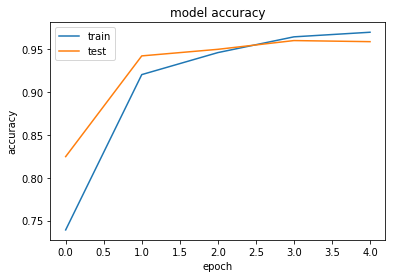

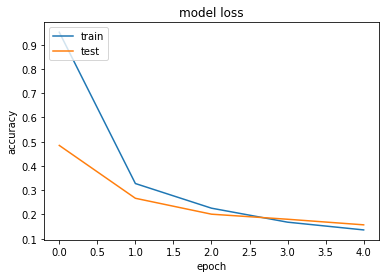

In [17]:
#Summarize hist for accuracy
plt.plot(hist_1.history['acc'])
plt.plot(hist_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

#summarize hist for loss
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

### Manual Verification of how the classification of Images are performed on the test data 

In [18]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.5, 
    zoom_range=0.4, 
    rescale=1./255,
    vertical_flip=True, 
    validation_split=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_generator = data_gen.flow_from_directory(
        PATH,
        target_size=(img_rows, img_cols), 
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb', 
        shuffle=True,  
        #save_to_dir=TRN_AUGMENTED, 
        #save_prefix='TrainAugmented', 
        #save_format='png', 
        subset="training")

Found 2983 images belonging to 10 classes.


In [19]:
test_generator.class_indices

{'BACKGROUND_Google': 0,
 'Faces': 1,
 'Faces_easy': 2,
 'Leopards': 3,
 'Motorbikes': 4,
 'airplanes': 5,
 'bonsai': 6,
 'car_side': 7,
 'grand_piano': 8,
 'watch': 9}

9


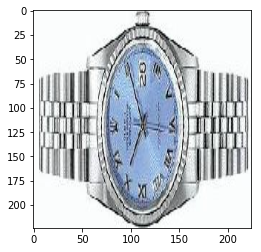

5


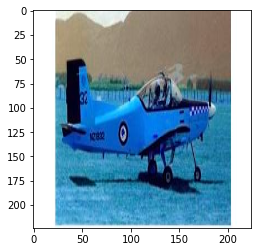

2


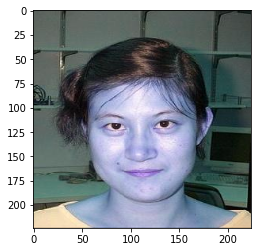

5


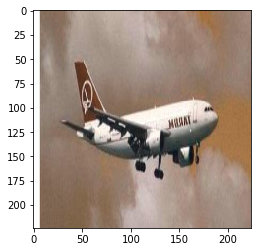

5


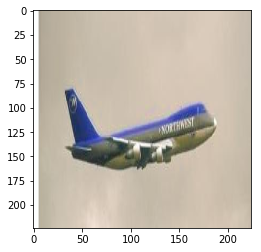

5


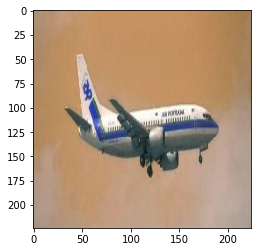

1


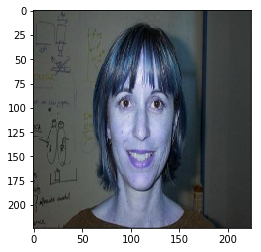

5


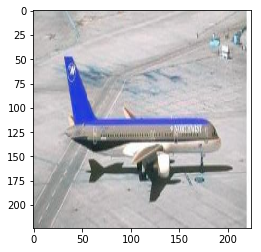

2


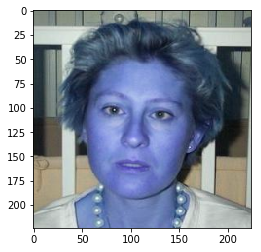

3


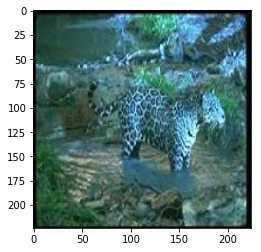

1


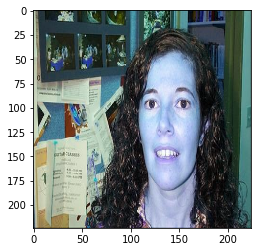

8


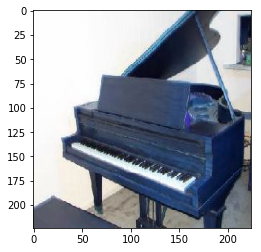

9


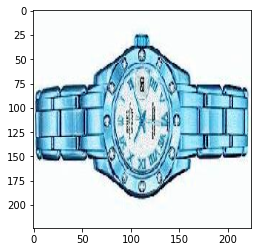

0


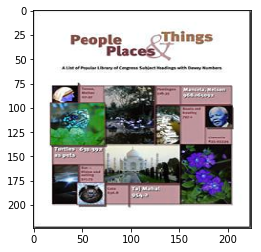

4


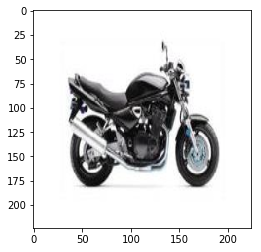

4


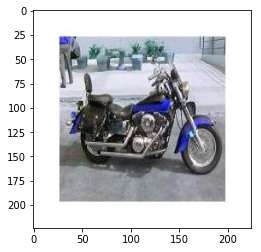

9


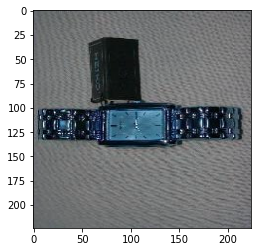

6


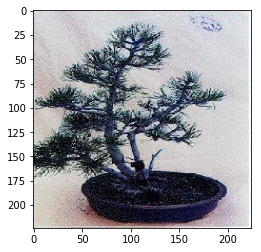

5


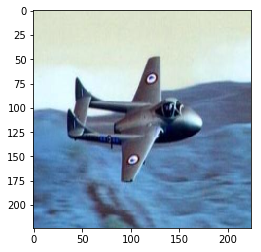

5


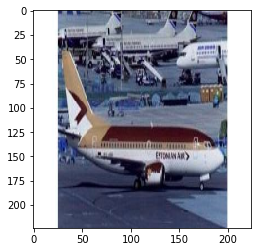

7


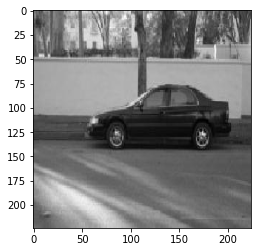

5


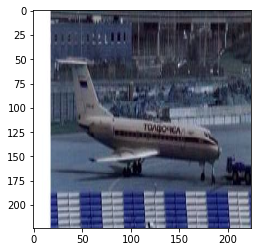

4


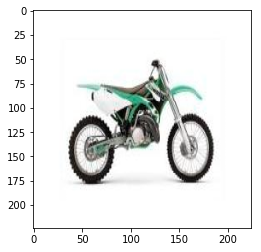

4


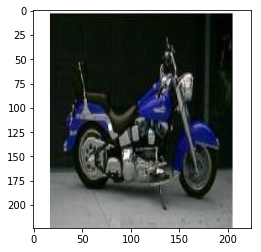

5


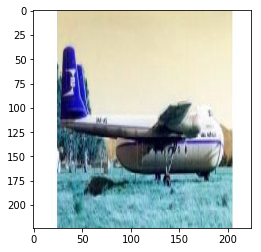

4


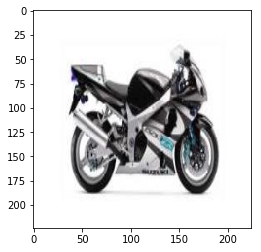

4


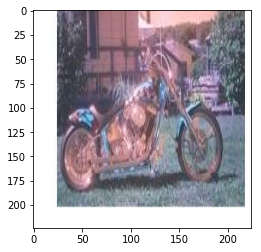

4


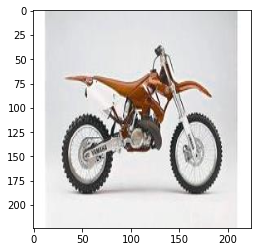

5


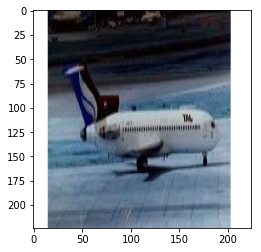

In [20]:

for i in range(1,30):
    plt.imshow(X_test[i])
    #plt.imshow(np.fliplr(X_test[i]))
    print(y_test_pred[i])
    plt.show(block=False)
    


In [21]:

PATH_TEST = '../input/testimage/test'
print(os.listdir(PATH_TEST))
data_dir_list_test = os.listdir(PATH_TEST)
print(data_dir_list_test)

['test']
['test']


In [22]:
img_data_list_test=[]
for dataset in data_dir_list_test:
    classes_names_list.append(dataset)
    print("Getting images from {} folder\n".format(dataset))
    img_list = os.listdir(PATH_TEST+'/'+ dataset)
    for img in img_list:
        input_img = cv2.imread(PATH_TEST + '/' + dataset + '/' + img)
        input_img_resize=cv2.resize(input_img,(img_rows,img_cols))
        img_data_list_test.append(input_img_resize)
       # target_column.append(dataset)

Getting images from test folder



In [23]:
img_data_test = np.array(img_data_list_test)
img_data_test = img_data_test.astype('float32')
img_data_test /= 255
print(img_data_test.shape)

(4, 224, 224, 3)


In [24]:
unseen_pred=cust_vgg_model.predict(img_data_test)
unseen_pred = np.argmax(unseen_pred,axis=1)

8


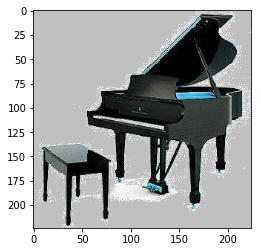

5


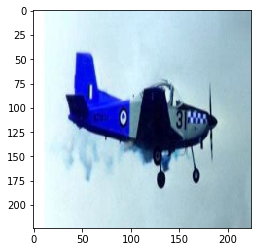

8


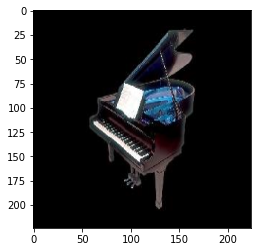

9


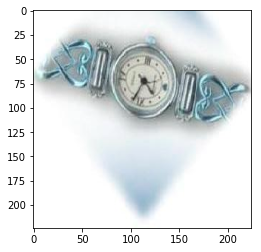

In [25]:
for i in range(0,4):
    plt.imshow(img_data_test[i])
    print(unseen_pred[i])
    plt.show(block=False)